In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (7.0, 5.5)

from astropy import units
from galpy.orbit import Orbit
from FerrersPotential import FerrersPotential as FP
from galpy.potential import PlummerPotential as PP

In [4]:
%%prun -s cumulative
pmw = FP(amp = 1, a = 8*units.kpc, b = 0.35, c = 0.2375, normalize = True, omegab = 10.*units.km/units.s/units.kpc)
ps = FP(amp = 1, a = 8*units.kpc, b = 1., c = 1., normalize = True, omegab = 10.*units.km/units.s/units.kpc)
ts = np.linspace(0,34,500)
omwa = Orbit(vxvv=[1,0.25,0.7,0,0.0,0]) #[R,vR,vT,z,vz,phi]
omwb = Orbit(vxvv=[1,0.25,0.7,0,0.0,0]) #[R,vR,vT,z,vz,phi]

omwa.integrate(ts, pmw, method = 'leapfrog')
omwb.integrate(ts, ps, method = 'leapfrog')

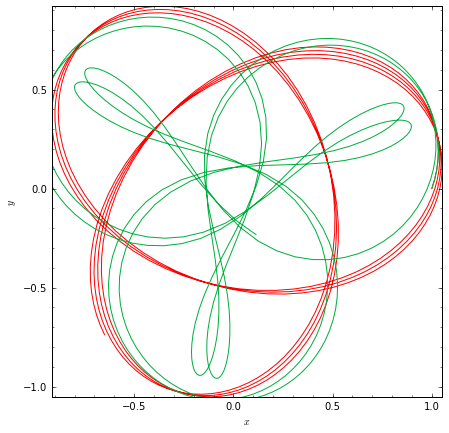

In [7]:
matplotlib.rcParams['figure.figsize'] = (7.0, 7.)
omwb.plot(d1 = 'x', d2 = 'y', overplot = False, color = 'red')
omwa.plot(d1 = 'x', d2 = 'y', overplot = True, color = '#00AF3F')

In [49]:
ts = np.linspace(0,500,5000)
omwf = Orbit(vxvv=[1,0.25,0.6,0,0.0,0]) #[R,vR,vT,z,vz,phi]
#omwg = Orbit(vxvv=[1,0.25,0.6,0,0.0,0]) #[R,vR,vT,z,vz,phi]
#omwfd = Orbit(vxvv=[1,0.25001,0.6,0,0.0,0]) #[R,vR,vT,z,vz,phi]

omwf.integrate(ts, pmw, method = 'leapfrog')
#omwfd.integrate(ts, pmw, method = 'leapfrog')
#omwg.integrate(ts, ps, method = 'leapfrog')

In [552]:
omwg.integrate(ts, ps, method = 'leapfrog')

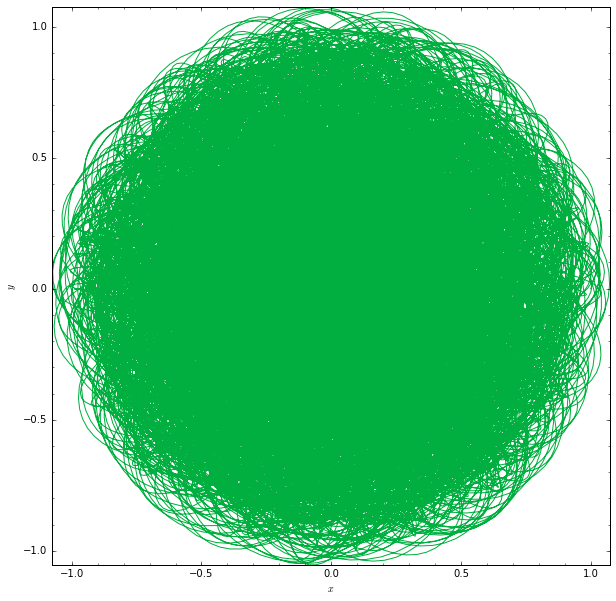

In [50]:
matplotlib.rcParams['figure.figsize'] = (10., 10.)
#omwg.plot('k.', d1 = 'R', d2 = 'vR', overplot = False, color = 'crimson')
omwf.plot('-', d1 = 'x', d2 = 'y', overplot = False, color = '#00AF3F')
#omwfd.plot('-', d1 = 'x', d2 = 'y', overplot = True, color = 'blue')

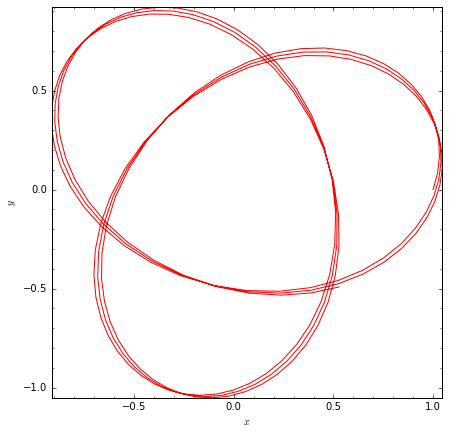

In [488]:
omwc = Orbit(vxvv=[1,0.25,0.7,0,0.0,0])
tsc = np.linspace(0,30,250)
omwc.integrate(tsc, ps, method = 'leapfrog')
omwc.plot(d1 = 'x', d2 = 'y', overplot = False, color = 'red')

[ 1.0001  0.25    0.7     0.      0.      0.    ]


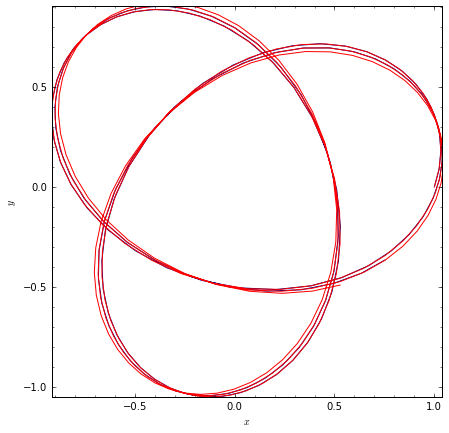

In [489]:
omwc.turn_physical_off()
icon = np.array([1.0001,0.25,0.7,0,0.0,0])
print(icon)
omwx = Orbit(vxvv=icon)
tsx = np.linspace(0,20,150)
omwx.integrate(tsx, ps, method = 'leapfrog')
omwx.plot(d1 = 'x', d2 = 'y', overplot = False, color = 'navy')
omwc.plot(d1 = 'x', d2 = 'y', overplot = True, color = 'red')

In [527]:
pp = PP(normalize = True)
op = Orbit(vxvv = [1.,.4,.93, 0.])
tsp = np.linspace(0,10,200)
op.integrate(tsp, pp,method = 'leapfrog')

In [ ]:
matplotlib.rcParams['figure.figsize'] = (7.0, 7.)
op.plot(d1 = 'x', d2 = 'y', overplot = False)

# ======================  useful functions  =========================

In [5]:
def rot(omega, t):
    temp = [[np.cos(t*omega), np.sin(t*omega)], [-np.sin(t*omega), np.cos(t*omega)]]
    return np.array(temp)

def inrotframe(x,y, ts, potential):
    xy = np.zeros([len(x),2])
    xy[:,0] = x
    xy[:,1] = y
    omega = potential.OmegaP()
    xrot, yrot = np.zeros(len(ts)), np.zeros(len(ts))
    for i in range(len(ts)):
        xrot[i],yrot[i] = np.dot(xy[i],rot(omega, ts[i]))
    return xrot, yrot

In [6]:
def allorbits(x,y):
    xo = [x[4*i] for i in range(int(len(x)/4))]
    xo1 = [x[4*i+1] for i in range(int(len(x)/4))]
    xo2 = [x[4*i+2] for i in range(int(len(x)/4))]
    xo3 = [x[4*i+3] for i in range(int(len(x)/4))]
    yo = [y[4*i] for i in range(int(len(x)/4))]
    yo1 = [y[4*i+1] for i in range(int(len(x)/4))]
    yo2 = [y[4*i+2] for i in range(int(len(x)/4))]
    yo3 = [y[4*i+3] for i in range(int(len(x)/4))]
    return [xo,yo],[xo1,yo1],[xo2,yo2],[xo3,yo3]

# ===========================  GALI  =============================

In [151]:
""" #1
name: devolist
input:
    list of initial conditions for the orbit [R,vR,vT,z,vz,phi]; icon
    in other than first iteration also 'indev', a list which contains normalized deviation vectors from previous
    iteration to be applied to the current state of the Orbit
    WARNING: Due to the method of creating the deviation vectors none of the coordinates can be zero!
             Otherwise at least two of them are linearly dependent!
output:
    list of initial conditions for deviated orbit; devos
"""
def devolist(icon, indev=None):
    devos = [] 
    if indev == None:
        reldev = 0.1
        dorb = icon[:]
        for i in range(len(icon)):
            dorb = icon[:]
            dorb[i] += dorb[i]*reldev
            if icon[i] != dorb[i]: 
                devos.append(dorb)
    else:
        for i in range(len(indev)):
            dorb = icon[:]
            dorb = list(np.array(dorb)+np.array(indev[i]))
            devos.append(dorb)
    return devos
# test
print(devolist([1,0.25,0.7,0.1,5.2,0.1], indev = [[1,0,0,0,0,0],[0,1,0,0,0,0],[0,2,1,0,0,0]]))

[[2.0, 0.25, 0.69999999999999996, 0.10000000000000001, 5.2000000000000002, 0.10000000000000001], [1.0, 1.25, 0.69999999999999996, 0.10000000000000001, 5.2000000000000002, 0.10000000000000001], [1.0, 2.25, 1.7, 0.10000000000000001, 5.2000000000000002, 0.10000000000000001]]


In [152]:
""" #2
name: evolveorbit
input:
    list of initial conditions for the orbit [R,vR,vT,z,vz,phi]; icon
    final time; tf
    potential; pot
output:
    list of orbit parameters in time tf;
"""
x = []
y = []
def evolveorbit(icon, tf, pot):
    global x
    global y
    o = Orbit(vxvv=icon) # [R,vR,vT,z,vz,phi]
    ts = np.linspace(0.,tf,10)
    o.integrate(ts, pot, method = 'leapfrog')
    x.append(o.x(ts[0]))
    y.append(o.y(ts[0]))
    return [o.R(tf),o.vR(tf),o.vT(tf),o.z(tf),o.vz(tf),o.phi(tf)] #for full 3D orbit
# test
#print(evolveorbit([1,0.25,0.7,0.1,5.2,0.1], 0.1, pmw))

In [153]:
""" #3
name: dvector
input:
    evolved orbit o and deviated orbit d
output:
    deviation vector w
"""
def dvector(o,d):
    return np.array(d)-np.array(o)

In [154]:
""" #4
name: matrixnorm
input:
    list of devitation vectors (np.arrays) to be normalized; wj
output:
    np.array of normalized deviation vectors; a
"""
def matrixnorm(wj):
    a = np.array(wj) # creates matrix consisting of k deviation vectors of dimension N
    k = len(a)
    for j in range(k):
        a[j] = abs(a[j] / np.linalg.norm(a[j]))
    return a

In [155]:
""" #5
name: galivalue
input:
    np.array of deviation vectors; a
output:
    value of gali at a specific time; g
"""
def galivalue(a):
    aT = np.transpose(a)
    s = np.linalg.svd(aT)[1] # creates array of singular values 
    return np.prod(s) # returns product of singular values ~ gali

# test:
#a = [[1,0,0],[1,0.01,0],[1,1,4]]
#galivalue(a)

In [156]:
a = [[1,0,0],[1,0.01,0],[1,1,4]]
aT = np.transpose(a)
aT

array([[ 1.  ,  1.  ,  1.  ],
       [ 0.  ,  0.01,  1.  ],
       [ 0.  ,  0.  ,  4.  ]])

In [158]:
"""
name: gali
input:
    initial conditions for the orbit
    renormalization time ~ timestep
    potential in which the Orbit is inspected
output:
    current value of gali, new IC for the Orbit, normalized dev. vectors in matrix for next step 
"""
def gali(o, tau, potential, w=None):
    if type(w) == type(None):
        v = devolist(list(o), indev = w)#deviated orbits from the Orbit
    else:
        v = w
    newo = evolveorbit(o, tau, potential) #evolves the Orbit
    wj = []
    for dorbit in v:
        #print(dorbit)
        #print(dorbit + o*(type(w) != type(None)))
        temp = evolveorbit(dorbit + o*(type(w) != type(None)), tau, potential) #evolves the deviated orbits to time tau
        #temp = evolveorbit(dorbit, tau, potential) #evolves the deviated orbits to time tau
        #print(temp)
        wj.append(dvector(o=newo,d=temp)) #creates list of deviation vectors in time tau
    #print(wj)
    a = matrixnorm(wj) #normalizes the matrix containing deviation vectors in time tau
    return galivalue(a), newo, np.array(wj) #returns value of gali, new IC for the Orbit, x-normalized-x dev. vectors in matrix 

# test
icon = np.array([1,.25,.7,.0,.0,.0])
test = gali(icon, .001, ps)
test

(0.99999501267736546,
 [1.0002497450225873,
  0.24949006620683417,
  0.69982522213407194,
  0.0,
  0.0,
  0.00069982516206865955],
 array([[  1.00000064e-01,   1.28978014e-04,   1.58442673e-05,
           0.00000000e+00,   0.00000000e+00,  -6.36060478e-05],
        [  2.50000023e-05,   2.50000066e-02,  -1.74908266e-05,
           0.00000000e+00,   0.00000000e+00,  -1.74907598e-08],
        [  5.14371488e-08,   1.02861455e-04,   6.99824826e-02,
           0.00000000e+00,   0.00000000e+00,   6.99824898e-05]]))

In [180]:
"""
name: galievol
input:
    initial conditions for the orbit
    renormalization time ~ timestep
    potential in which the Orbit is inspected
    maximum time Tm and small treshold value of the GALI Gm
output:
    42 (and list of GALI values during the integration) 
"""
def galievol(o,tau, potential, Tm, Gm):
    global x
    global y
    x,y = [],[]
    galis = np.zeros([1+int(Tm/tau),2]) # array large enough
    continuing = True # stopping flag
    i = 1 # counter
    w = None #initial setting
    while continuing:
        galis[i-1][1], newo, a = gali(o, tau, potential, w)
        galis[i-1][0] = tau*i
        if galis[i-1][1]<Gm:
            print('if this code works, the orbit is chaotic')
            continuing = False
            return galis[:i-1][:]
        if i*tau > Tm:
            print('time reached treshold, orbit is regular if this code works')
            continuing = False
            return galis[:][:]
        i += 1
        o = newo
        w = a

In [59]:
orb = Orbit(vxvv = [0.2,-.6,.5, 0.,0.,0.])
timespan = np.linspace(0,300,3000)
orb.integrate(timespan, ps, method = 'leapfrog')

(-0.5, 0.5)

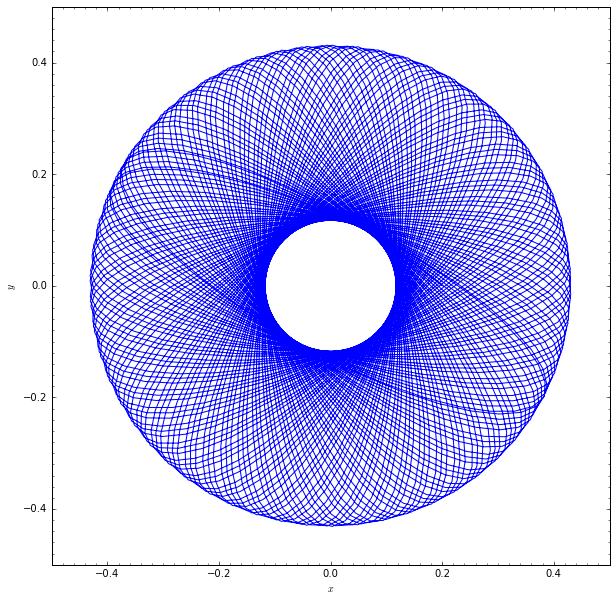

In [60]:
orb.plot(d1 = 'x', d2 = 'y')
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)

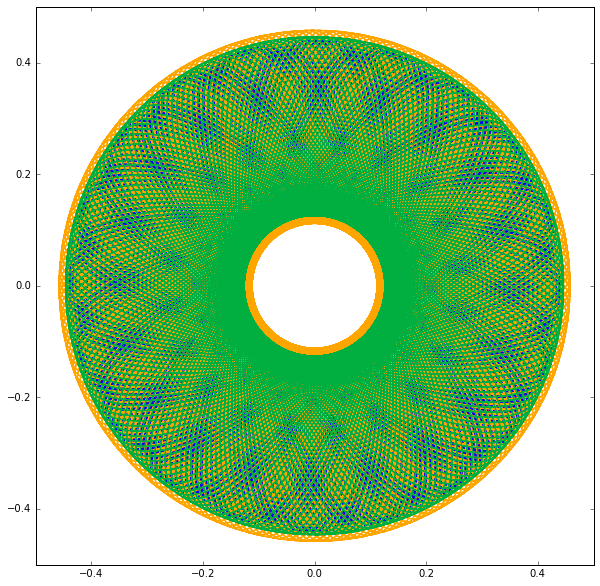

In [167]:
matplotlib.rcParams['figure.figsize'] = (10, 10)
[xo,yo],[xo1,yo1],[xo2,yo2],[xo3,yo3] = allorbits(x,y)
plt.plot(xo[30:], yo[30:], c = 'crimson')
plt.plot(xo1[30:], yo1[30:], c = 'blue')
plt.plot(xo2[30:], yo2[30:], c = 'orange')
plt.plot(xo3[30:], yo3[30:], c = '#00AF3F')
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.show()

In [162]:
for i in range(len(results)):
    if x[i]>0.45:
        print(x[i], results[i])

In [165]:
ps = FP(amp = 1, a = 8*units.kpc, b = 1., c = 1., normalize = True, omegab = 10.*units.km/units.s/units.kpc)
icon = np.array([.2,-.6,.5, 0.,0.,0.]) # 11:54 - 
tau = 10**-2
Tm = 1000
Gm = 10**-16
results = galievol(icon, tau, ps, Tm, Gm)

time reached treshold, orbit is regular if this code works


(100, 110)

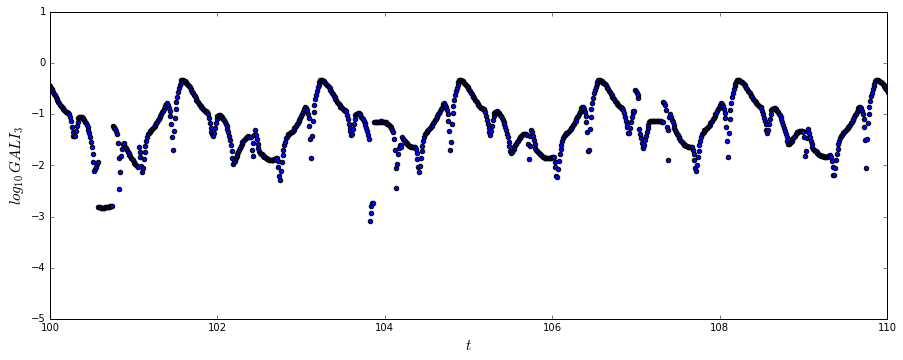

In [168]:
matplotlib.rcParams['figure.figsize'] = (15.0, 5.5)
plt.scatter((results[:,0]), np.log10(results[:,1]))
plt.xlabel(r'$t$', fontsize = 15)
plt.ylabel(r'$log_{10}\,GALI_3$', fontsize = 15)
plt.xlim(100,110)

In [186]:
%%prun -s cumulative
Tm=50000. # 4:28 - 4:36 for 300 pts
tau = 5*10**-2
Gm = 10**-18
# orbit in rotating Ferrers Potential
pmw = FP(amp = 1, a = 8*units.kpc, b = 0.35, c = 0.2375, normalize = True, omegab = 10.*units.km/units.s/units.kpc)
icon = np.array([1.,0.25,0.6,0.,0,0])
results8 = galievol(icon, tau, pmw, Tm, Gm)

/home/annaj/anaconda3/lib/python3.5/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)



KeyboardInterrupt: 

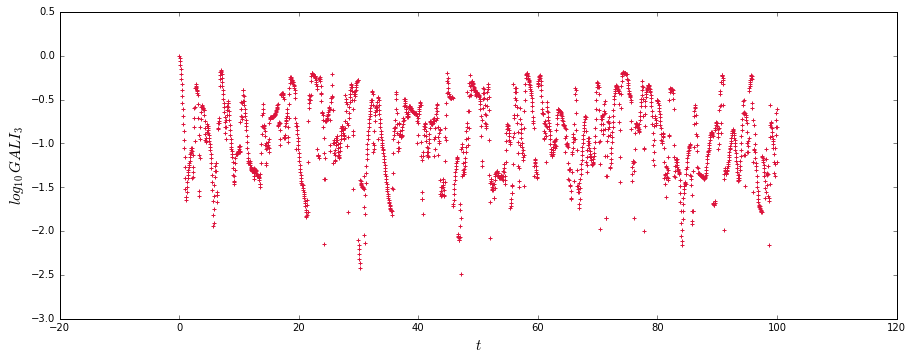

In [188]:
matplotlib.rcParams['figure.figsize'] = (15.0, 5.5)
plt.scatter((results8[:,0]), np.log10(results8[:,1]),marker = '+', c= 'crimson') #initial deviation 1%
plt.xlabel(r'$t$', fontsize = 15)
plt.ylabel(r'$log_{10}\,GALI_3$', fontsize = 15)
#plt.xlim(0,100)

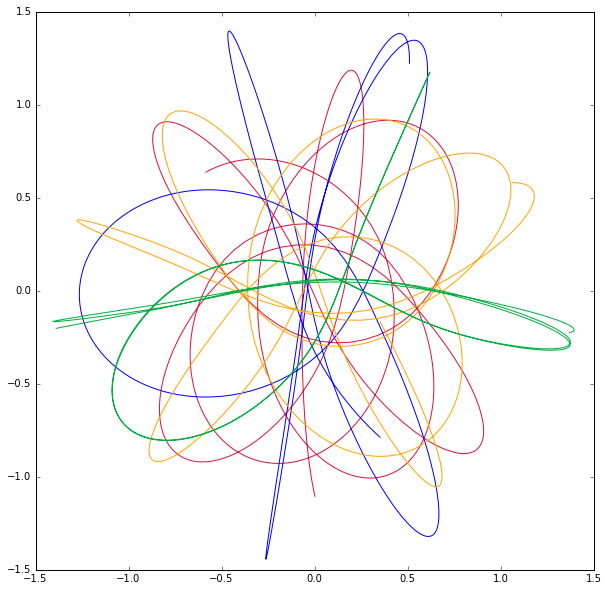

In [191]:
matplotlib.rcParams['figure.figsize'] = (10, 10)
[xo,yo],[xo1,yo1],[xo2,yo2],[xo3,yo3] = allorbits(x,y)
plt.plot(xo[-600:], yo[-600:], c = 'crimson')
plt.plot(xo1[-600:], yo1[-600:], c = 'blue')
plt.plot(xo2[-600:], yo2[-600:], c = 'orange')
plt.plot(xo3[-600:], yo3[-600:], c = '#00AF3F')
#plt.xlim(-0.5,0.5)
#plt.ylim(-0.5,0.5)
plt.show()

(0, 100)

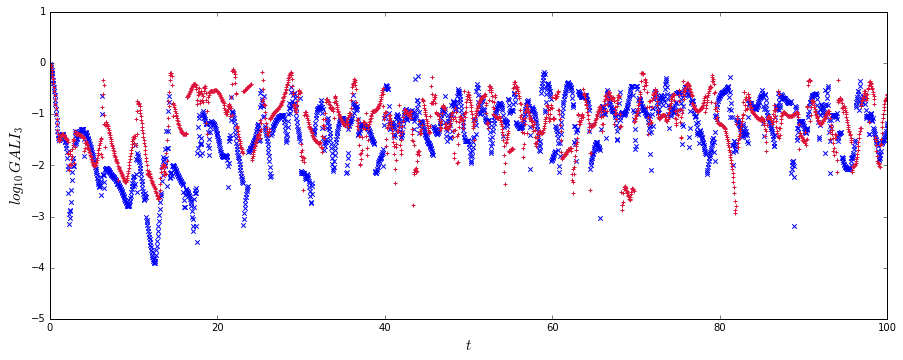

In [113]:
matplotlib.rcParams['figure.figsize'] = (15.0, 5.5)
plt.scatter((results7[:,0]), np.log10(results7[:,1]),marker = 'x', c= 'blue') #initial deiviation 0.1%
plt.scatter((results8[:,0]), np.log10(results8[:,1]),marker = '+', c= 'crimson') #initial deviation 1%
plt.xlabel(r'$t$', fontsize = 15)
plt.ylabel(r'$log_{10}\,GALI_3$', fontsize = 15)
plt.xlim(0,100)

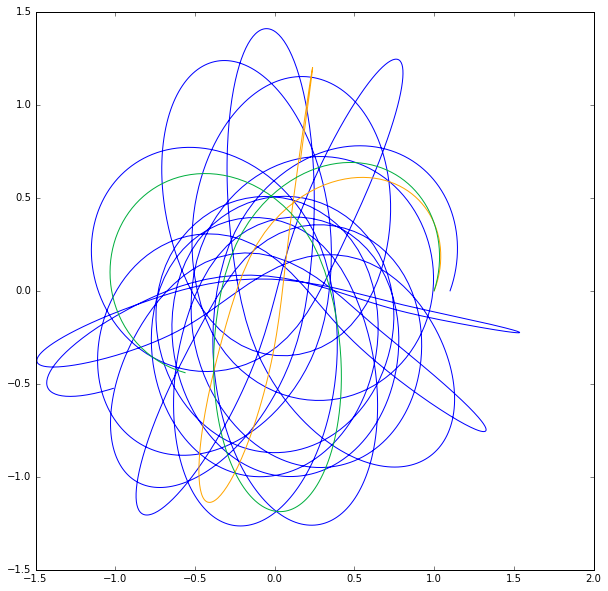

In [185]:
[xo,yo],[xo1,yo1],[xo2,yo2],[xo3,yo3] = allorbits(x,y)
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
#plt.plot(xo[:], yo[:], c = 'crimson')
plt.plot(xo1[:], yo1[:], c = 'blue')
plt.plot(xo2[:200], yo2[:200], c = 'orange')
plt.plot(xo3[:200], yo3[:200], c = '#00AF3F')
#print(len(xo[:]))
#plt.xlim(-2,2)
#plt.ylim(-2,2)
plt.show()

In [85]:
for i in range(len(xo)-1):
    print(xo[i]-xo[i+1])

0.0
-0.0112684216547
-0.00887644390547
-0.00658504091543
-0.00438562613379
-0.00226938357809
-0.000228008522861
0.00174604723523
0.00365954030619
0.00551848234915
0.00732821354846
0.00909347993746
0.0108185053646
0.012507054883
0.0141624889137
0.0157878085688
0.017385692871
0.018958528638
0.0205084336991
0.0220372739461
0.023546674534
0.0250380253369
0.0265124805433
0.0279709520244
0.0294140958128
0.0308422906753
0.0322556073047
0.0336537660618
0.0350360803904
0.0364013819127
0.0377479216314
0.0390732393812
0.0403739902898
0.0416457119016
0.0428825076803
0.0440766099472
0.0452177644357
0.0462923478872
0.0472820326814
0.0481617891039
0.0488966173685
0.0494360209362
0.0497038437345
0.0495775765118
0.0488530291575
0.0472436370959
0.044481749839
0.0405223685321
0.0357207023332
0.0307468264202
0.0262416469785
0.0225368217649
0.0196195894032
0.0172785446409
0.015330402732
0.0136659762758
0.0122157980837
0.0109327003179
0.00978313208152
0.00874241926477
0.00779189022482
0.00691709645665
0.006

In [14]:
%%prun -s cumulative
Tm=5000. # 9964.733 seconds for T = 5000 ~2h45m
tau = 5*10**-2
Gm = 10**-12
# orbit in rotating Ferrers Potential
pmw = FP(amp = 1, a = 8*units.kpc, b = 0.35, c = 0.2375, normalize = True, omegab = 10.*units.km/units.s/units.kpc)
icon = np.array([1.,0.25,0.6,0.])
results_1 = galievol(icon, tau, pmw, Tm, Gm)

time reached treshold, orbit is regular if this code works
 

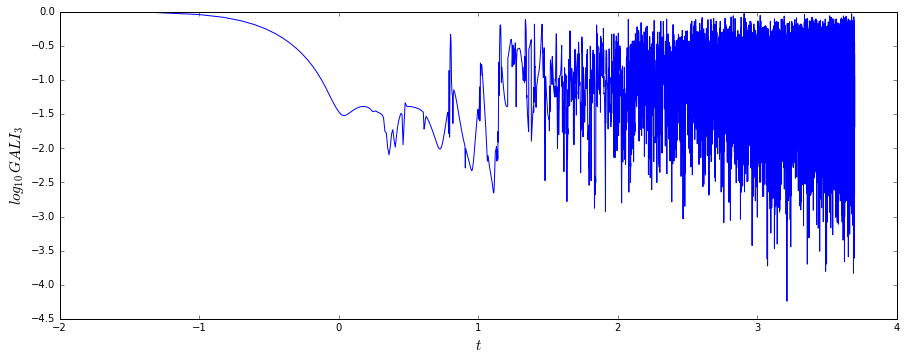

In [37]:
matplotlib.rcParams['figure.figsize'] = (15.0, 5.5)
plt.plot(np.log10(results_1[:,0]), np.log10(results_1[:,1]), c= 'blue')
plt.xlabel(r'$t$', fontsize = 15)
plt.ylabel(r'$log_{10}\,GALI_3$', fontsize = 15)
#plt.xlim(0,5000)

100002


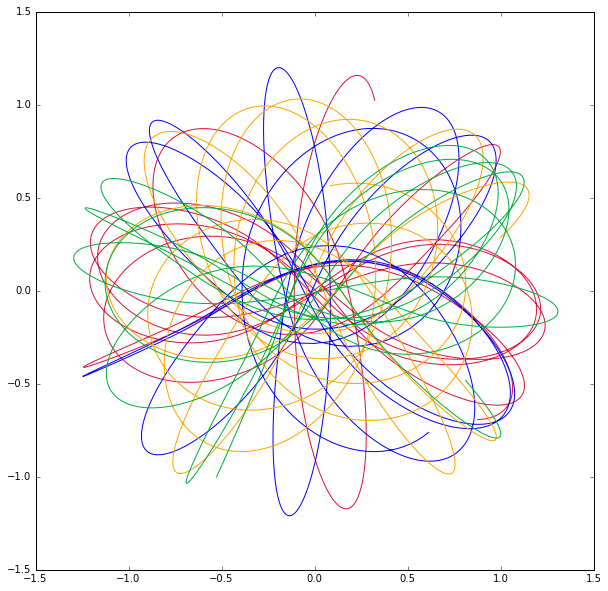

In [54]:
matplotlib.rcParams['figure.figsize'] = (25, 25)
[xo,yo],[xo1,yo1],[xo2,yo2],[xo3,yo3] = allorbits(x,y)
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(xo[99000:], yo[99000:], c = 'crimson')
plt.plot(xo1[99000:], yo1[99000:], c = 'blue')
plt.plot(xo2[99000:], yo2[99000:], c = 'orange')
plt.plot(xo3[99000:], yo3[99000:], c = '#00AF3F')
#print(len(xo[:]))
#plt.xlim(-2,2)
#plt.ylim(-2,2)
print(len(xo))
plt.show()

In [58]:
ts = np.linspace(0,5000,50000)
xr, yr = inrotframe(xo,yo, ts, pmw)
xr1, yr1 = inrotframe(xo1,yo1, ts, pmw)
xr2, yr2 = inrotframe(xo2,yo2, ts, pmw)
xr3, yr3 = inrotframe(xo3,yo3, ts, pmw)

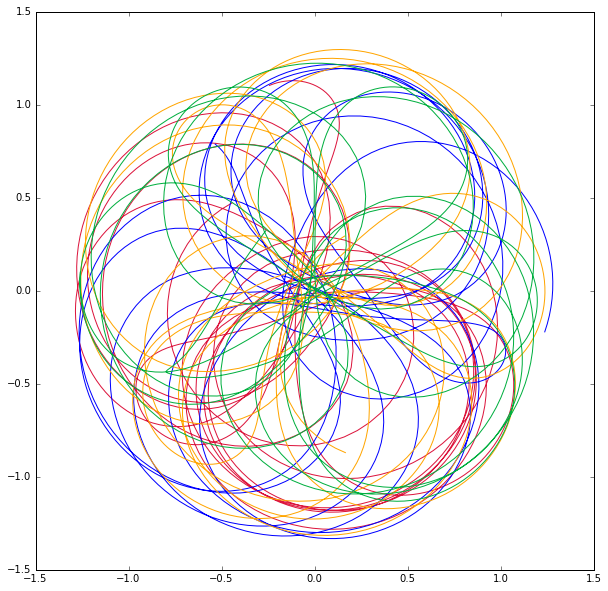

In [62]:
plt.plot(xr[49000:], yr[49000:], c = 'crimson')
plt.plot(xr1[49000:], yr1[49000:], c = 'blue')
plt.plot(xr2[49000:], yr2[49000:], c = 'orange')
plt.plot(xr3[49000:], yr3[49000:], c = '#00AF3F')
